# **Übung 2_2: Eigengesichter**

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os, os.path # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.spatial import distance

In [2]:
pd.show_versions(as_json=False)
np.__version__

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



INSTALLED VERSIONS
------------------
commit           : 67a3d4241ab84419856b84fc3ebc9abcbe66c6b3
python           : 3.6.9.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.112+
Version          : #1 SMP Thu Jul 23 08:00:38 PDT 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.4
numpy            : 1.18.5
pytz             : 2018.9
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 50.3.2
Cython           : 0.29.21
pytest           : 3.6.4
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : 0.4.1
xlsxwriter       : None
lxml.etree       : 4.2.6
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.11.2
IPython          : 5.5.0
pandas_datareader: 0.9.0
bs4              : 4.6.3
bottleneck       : 1

'1.18.5'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/My Drive/Maschinelles Lernen/Übungen/lfw_funneled"
list = os.listdir(path) # dir is directory path

df=pd.DataFrame(columns={"name", "count"})
for element in list:
  subpath = os.path.join(path, element)
  if os.path.isdir(subpath):
    sublist = os.listdir(subpath)
    number_files = len(sublist)

    new_element=pd.DataFrame({"name": element, "count": number_files}, index=[0])
    #new_element=pd.Series(element, number_files)
    #print(new_element)
    df=pd.concat([df, new_element], ignore_index=True)
    #df.append(new_element)

**Tests with Ariel**

(250, 250)


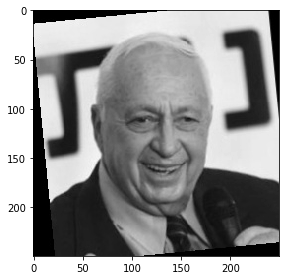

In [ ]:
ariel = io.imread("/content/drive/My Drive/Maschinelles Lernen/Übungen/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0010.jpg", as_gray= True)
print(ariel.shape)
io.imshow(ariel)

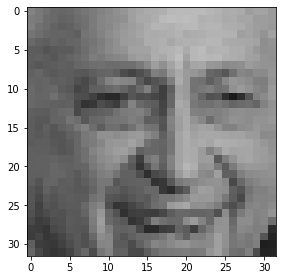

In [ ]:
# crop image: image[y1:y2, x1:x2]
ariel2 = ariel[75:175,75:175]

# rescale image
ariel2 = rescale(ariel2, 0.32, anti_aliasing=False) #anti_aliasing für eindeutigere Pixel?
io.imshow(ariel2)

In [ ]:
stacked = ariel2.flatten().T
#stacked.size
stacked

array([0.51432441, 0.47966153, 0.4487659 , ..., 0.29810824, 0.13419347,
       0.13898968])

In [ ]:
stacked_reshape = np.reshape(ariel2, (32,32))
stacked_reshape.shape

(32, 32)

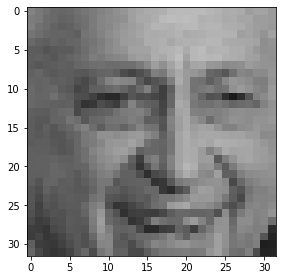

In [ ]:
io.imshow(stacked_reshape)

In [ ]:
df2 = pd.DataFrame(stacked).T
name = {'name': ['Ariel_Sharon']}
name = pd.DataFrame(name)
df2 = name.join(df2)
print(df2.shape)
df2.head()

(1, 1025)


,name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Ariel_Sharon,0.514324,0.479662,0.448766,0.408544,0.399956,0.409162,0.434683,0.462304,0.482866,0.509666,0.53317,0.561378,0.589045,0.625653,0.65012,0.669363,0.672384,0.687417,0.722084,0.727254,0.725499,0.72746,0.729406,0.711572,0.697395,0.674598,0.678383,0.664087,0.616794,0.640044,0.638613,0.602737,0.485067,0.478234,0.424729,0.415524,0.389965,0.395071,0.426802,...,0.624006,0.565038,0.465482,0.486067,0.467997,0.497328,0.120639,0.130906,0.394573,0.281947,0.227387,0.206421,0.222727,0.26323,0.341601,0.409483,0.296827,0.463277,0.516133,0.379777,0.380251,0.292425,0.281361,0.366367,0.42308,0.465753,0.474759,0.483601,0.489206,0.476926,0.488002,0.584696,0.629479,0.542888,0.448218,0.427422,0.498438,0.298108,0.134193,0.13899




---



**a.) Erstellen Sie ein Python-Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren.**

In [5]:
df["name"].duplicated().any()

False

In [6]:
df["count"].max()

530

In [7]:
#df["MoreThan70"]=np.where(df["Count"] >= 70, True, False)
NamesOver70=df.loc[df["count"]>=70]

In [8]:
NamesOver70

,name,count
701,Tony_Blair,144
3127,George_W_Bush,530
3145,Gerhard_Schroeder,109
3423,Hugo_Chavez,71
4296,Colin_Powell,236
4650,Donald_Rumsfeld,121
5372,Ariel_Sharon,77


In [9]:
#df.reset_index(drop=True)
#row = pd.DataFrame(df.iloc[0]).T
#print(row)
#dataframe = pd.DataFrame()
#pd.concat([row, dataframe])

**b.) Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden
später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen
lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt.**

In [10]:
def loadTrain(dataframe, path):
  Train = pd.DataFrame()

  for element in dataframe["name"]:                                # bei allen Namen, die im Dataframe enthalten sind
    subpath = os.path.join(path, element)                          # merke dir diesen subpath : .../Tony_Blair

    for picture in os.listdir(subpath):                           # für jedes Bild außer das letzte, das in diesem subpath drin ist          
      picPath = os.path.join(subpath, picture)
      img = io.imread(picPath, as_gray = True)                    # lies das Bild in grau ein
      img = img[75:175,75:175]                                   # schneide das Bild mittig zu, sodass Mund und Augen drauf sind
      img = rescale(img, 0.32, anti_aliasing= False)        # rescale auf 32x32
      img = pd.DataFrame(img.flatten()).T                        # stack in 1D array aka vector.T 1x1024

      name = {'name': [element]}                  # extract the name
      name = pd.DataFrame(name)                   # save name in DataFrame

      complete = name.join(img)                    # join name and image vector so that vector.T 1x1025

      Train = pd.concat([Train, complete], ignore_index = True)
      
  Train.reset_index()
  return Train

In [11]:
def loadTest(dataframe, Train):
  Test = pd.DataFrame()
  drops = []

  for name in dataframe["name"]:
    #print(name)
    lastPicIndex = Train.name.where(Train.name == name).last_valid_index()
    row = pd.DataFrame(Train.iloc[lastPicIndex]).T
    #print(lastPicIndex)
    Test = pd.concat([Test, row], ignore_index = True)
    #Test = pd.concat([Test, lastPicIndex, Train])
    
    drops = np.insert(drops,0,lastPicIndex)
    
  #print(drops)
  Train = Train.drop(drops)

  return Test, Train


In [12]:
DM = loadTrain(NamesOver70, path)
print(DM.shape)
#DM.head(100)

(1288, 1025)


In [13]:
Test, Train= loadTest(NamesOver70, DM)

In [14]:
print(Test.shape)
print(Train.shape)

(7, 1025)
(1281, 1025)


**c. Wenden Sie nun Ihre Hauptkomponentenanalyse aus Aufgabe 1 auf Ihre Designmatrix
(Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame
Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12
Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat
dar. Interpretieren Sie das Ergebnis**

In [15]:
def PCA_prep(df):

  #dfN = (dfC - dfC.min()) / (df.max() - dfC.min())
  dfS = (df-df.mean())/df.std() # Standardisation so that variance = 1

  X = np.asmatrix(dfS)
  n = len(df.index)

  U,D,VT = np.linalg.svd(X, full_matrices=False)

  D_diag = np.diag(D)
  UD = np.dot(U,D_diag)     # Neuen Projektionen (scores, ai)

  D2 = D*D/(n-1)            #(14,) Varianzen der neuen Hauptkomponenten sortiert nach Größe, Eigenwerte
  D_explainedV = D2/D2.sum()
  D_explainedVcum = D_explainedV.cumsum()
  Variance = pd.DataFrame(data = {'Varianz': D2, 'Erklärte Varianz': D_explainedV, 'kumulierte erklärte Varianz': D_explainedVcum})

  return Variance, U, UD, D2, VT

In [16]:
Train_NoName = Train.drop(['name'], axis = 1)
Train_NoName

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.154156,0.148562,0.345404,0.407933,0.423340,0.435188,0.446016,0.459766,0.464111,0.490770,0.525652,0.524819,0.524351,0.523330,0.523871,0.547481,0.577976,0.593761,0.571155,0.593852,0.585704,0.590492,0.542246,0.509918,0.523829,0.571401,0.550178,0.524632,0.183095,0.212454,0.310356,0.297100,0.145236,0.300693,0.423591,0.442118,0.456256,0.450553,0.450588,0.489285,...,0.632766,0.651750,0.673464,0.625963,0.616198,0.583023,0.544917,0.517991,0.065604,0.055880,0.143364,0.386252,0.397361,0.412253,0.417762,0.428154,0.443595,0.437366,0.492636,0.526621,0.538997,0.544568,0.550585,0.528466,0.530799,0.522471,0.560194,0.569822,0.603784,0.622528,0.611592,0.622591,0.649396,0.657474,0.660505,0.621346,0.615953,0.558442,0.535993,0.585219
1,0.645656,0.513955,0.557862,0.670317,0.815313,0.846690,0.903062,0.894617,0.867535,0.864737,0.878079,0.873777,0.854470,0.813486,0.814758,0.798541,0.766668,0.747792,0.712225,0.675093,0.657720,0.680463,0.662869,0.600990,0.558399,0.511504,0.466200,0.477434,0.408411,0.414732,0.336016,0.314472,0.611520,0.479903,0.506194,0.711610,0.801161,0.809028,0.870492,0.868970,...,0.401909,0.482183,0.408220,0.415650,0.489390,0.625702,0.616264,0.613806,0.296504,0.983146,0.914033,0.466559,0.392821,0.436142,0.465737,0.520244,0.549962,0.557743,0.630942,0.662455,0.620888,0.575429,0.517434,0.454436,0.428977,0.372541,0.385313,0.392777,0.355141,0.350665,0.377774,0.386287,0.427215,0.407562,0.392060,0.414955,0.471022,0.492286,0.473144,0.470767
2,0.256311,0.320412,0.563050,0.444234,0.666266,0.753937,0.758665,0.752981,0.769149,0.748153,0.736850,0.708515,0.731087,0.725318,0.720000,0.717648,0.716396,0.707243,0.699303,0.676153,0.674182,0.679492,0.670856,0.660821,0.649546,0.634550,0.618196,0.541596,0.492181,0.416998,0.355230,0.334620,0.363292,0.557374,0.481984,0.496008,0.661212,0.757916,0.735966,0.705812,...,0.571185,0.498408,0.525509,0.489207,0.471355,0.527736,0.550534,0.581073,0.207539,0.270608,0.285712,0.325952,0.256053,0.200286,0.232244,0.438517,0.538387,0.631655,0.584044,0.482762,0.390368,0.378255,0.392024,0.387004,0.398531,0.404636,0.403135,0.428484,0.507965,0.555082,0.606138,0.611678,0.541875,0.519533,0.499924,0.461697,0.507075,0.525712,0.539793,0.747862
3,0.245177,0.274741,0.460021,0.553435,0.568711,0.563047,0.584204,0.611026,0.617842,0.621003,0.613886,0.633110,0.671201,0.680591,0.726017,0.726133,0.741561,0.781184,0.813346,0.839142,0.890665,0.901835,0.903142,0.916840,0.900784,0.853560,0.745811,0.546512,0.477191,0.501282,0.408413,0.435294,0.242895,0.280297,0.517936,0.555718,0.552589,0.525081,0.553710,0.592917,...,0.668501,0.704108,0.673641,0.605458,0.657452,0.756687,0.149709,0.053609,0.380057,0.387853,0.346637,0.312415,0.318078,0.373435,0.366769,0.363280,0.381514,0.354033,0.313479,0.294876,0.284330,0.310174,0.347580,0.342796,0.431643,0.566324,0.628897,0.673088,0.664694,0.649501,0.651656,0.659315,0.660830,0.684507,0.622245,0.644522,0.685243,0.791822,0.191637,0.057180
4,0.182847,0.220756,0.277191,0.391927,0.506138,0.570280,0.590495,0.602969,0.656358,0.692729,0.699334,0.693917,0.701923,0.728297,0.740412,0.753461,0.764088,0.786880,0.781671,0.761552,0.745052,0.728641,0.715555,0.709706,0.694047,0.690584,0.703044,0.675821,0.647834,0.565794,0.447702,0.496421,0.179103,0.240773,0.279058,0.400410,0.509465,0.575496,0.588244,0.594921,...,0.599425,0.576228,0.543414,0.500668,0.503210,0.616392,0.663715,0.099544,0.102884,0.095349,0.090076,0.108312,0.249783,0.796808,0.443724,0.529283,0.551437,0.471199,0.466837,0.514787,0.624669,0.616058,0.649912,0.603004,0.692196,0.634832,0.602772,0.622218,0.636247,0.588613,0.586917,0.620385,0.583090,0.550858,0.507788,0.504261,0.480443,0.563697,0.787813,0.242507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [17]:
PCA_comp = PCA_prep(Train_NoName)

PCA_comp_var = PCA_comp[0]
U = pd.DataFrame(data = PCA_comp[1])
UD = pd.DataFrame(data = PCA_comp[2])
D2 = PCA_comp[3]
VT=PCA_comp[4]

In [18]:
PCA_comp_var.head(20)

,Varianz,Erklärte Varianz,kumulierte erklärte Varianz
0,263.880302,0.257696,0.257696
1,156.039482,0.152382,0.410078
2,64.046692,0.062546,0.472624
3,58.478792,0.057108,0.529732
4,34.319945,0.033516,0.563247
5,27.966393,0.027311,0.590558
6,23.378683,0.022831,0.613389
7,18.382821,0.017952,0.631341
8,15.941294,0.015568,0.646909
9,12.969519,0.012666,0.659574


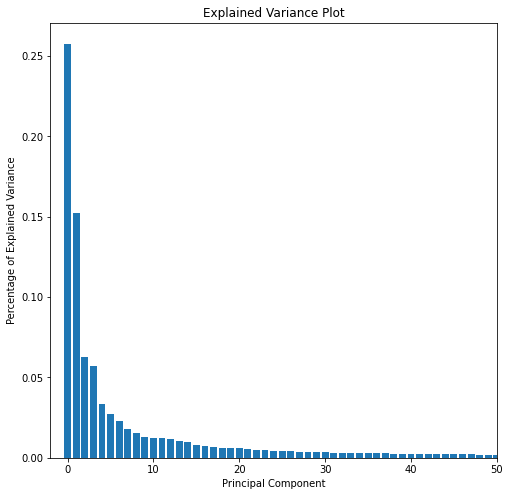

In [19]:
plt.figure(figsize=(8,8))
plt.bar(x = range(0,len(PCA_comp_var)),height = PCA_comp_var['Erklärte Varianz'])
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Explained Variance Plot')
plt.xlim(-2,50)
plt.show()

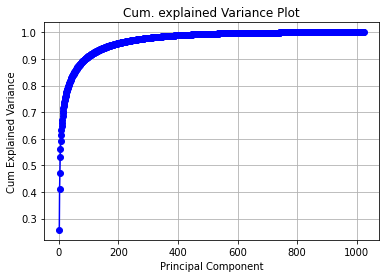

In [20]:
plt.plot(range(1,len(PCA_comp_var)+1), PCA_comp_var['kumulierte erklärte Varianz'], 'bo-')
plt.grid()
plt.ylabel('Cum Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cum. explained Variance Plot')
plt.show()

              0          1          2  ...      1022      1023          name
0     -5.943642 -10.024690   2.070217  ... -0.002502  0.012501    Tony_Blair
1      7.779215  19.069185  -7.599902  ...  0.015110  0.002824    Tony_Blair
2      2.181059  -3.294207  -4.942523  ... -0.006877  0.017789    Tony_Blair
3     11.995367 -25.641009  -6.798943  ...  0.021074 -0.013093    Tony_Blair
4      8.617423 -13.526800   2.346604  ...  0.019985  0.033042    Tony_Blair
...         ...        ...        ...  ...       ...       ...           ...
1276   4.584079   1.240776   3.716869  ...  0.005756 -0.015383  Ariel_Sharon
1277 -11.204197  -4.191897  -8.676342  ... -0.019691 -0.006734  Ariel_Sharon
1278 -52.521848  22.847568 -18.326481  ...  0.000122 -0.007070  Ariel_Sharon
1279  -3.871083  25.734886 -19.835752  ...  0.010512  0.003738  Ariel_Sharon
1280   3.701141  25.398237 -16.428856  ... -0.020007  0.000598  Ariel_Sharon

[1281 rows x 1025 columns]


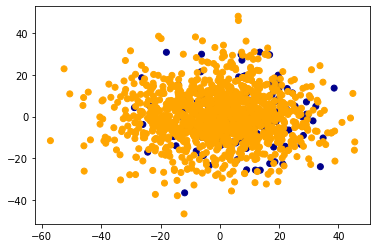

In [38]:
UD_Name = UD
UD_Name['name'] = Train['name']
print(UD_Name)
color = UD_Name['name']
color = ['darkblue' if name=='Tony_Blair' else 'orange' for name in UD_Name["name"]]
scatter=plt.scatter(x=UD_Name[0], y=UD_Name[1], c=color)

#scatter = UD.plot.scatter(x = 0, y = 1)
scatter

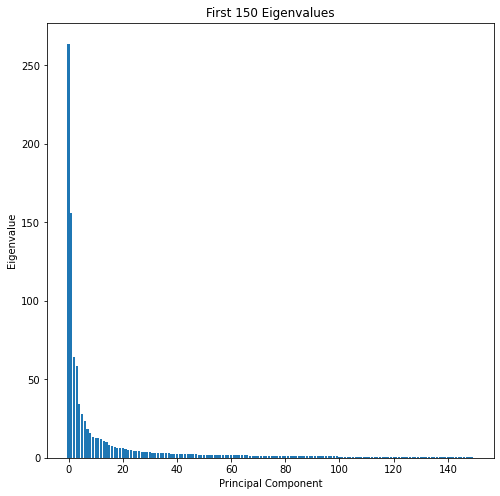

In [22]:
D2.shape
plt.figure(figsize=(8,8))
plt.bar(x = range(0,150),height = D2[:150])
plt.ylabel('Eigenvalue')
plt.xlabel('Principal Component')
plt.title('First 150 Eigenvalues')
#plt.xlim(-2,50)
plt.show()

In [23]:
VT.shape

(1024, 1024)

In [24]:
Eigenfaces = VT[:12]
Eigenfaces.shape

(12, 1024)

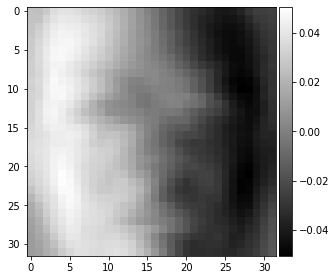

In [25]:
Eigenvalues_restacked = np.reshape(Eigenfaces[1],(32,32))
io.imshow(Eigenvalues_restacked, cmap=plt.cm.gray)

In [26]:
def plot_gallery(images, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((32, 32)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

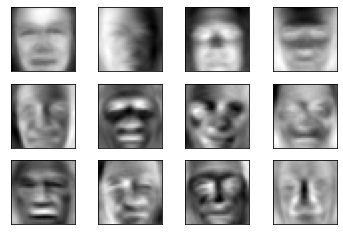

In [27]:
plot_gallery(Eigenfaces)

**d. Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s.
Schritt 1 im Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten
7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die
Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes
in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person
des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist
dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator).
Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?**


In [ ]:
def PCA_prep_Test(Test):
  #Test = Test-Train.mean()
  #Test = (Test-Train.mean())/Test.std() # Standardisation so that variance = 1

  X = np.asmatrix(Test)
  n = len(Test.index)

  U,D,VT = np.linalg.svd(X, full_matrices=False)

  D_diag = np.diag(D)
  UD = np.dot(U,D_diag)     # Neuen Projektionen (scores, ai)

  D2 = D*D/(n-1)            #(14,) Varianzen der neuen Hauptkomponenten sortiert nach Größe, Eigenwerte
  D_explainedV = D2/D2.sum()
  D_explainedVcum = D_explainedV.cumsum()
  Variance = pd.DataFrame(data = {'Varianz': D2, 'Erklärte Varianz': D_explainedV, 'kumulierte erklärte Varianz': D_explainedVcum})

  return Variance, U, UD, D2, VT

In [ ]:
Test_NoName = Test.drop(['name'], axis = 1)

#Train_NoName=Train_NoName[:7]
Train_NoName.shape
Test_NoName = (Test_NoName - Train_NoName.mean())
Test_NoName

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.208719,0.23632,0.218803,0.281694,0.173968,0.177482,0.16448,0.159975,0.133848,0.107742,0.0652599,0.0482818,0.0297072,0.0230396,0.0036155,0.0149371,0.0103465,0.0515255,0.0679431,0.0923719,0.0966678,0.132004,0.189002,0.211874,0.211029,0.212154,0.235636,0.240026,0.0666288,0.0424465,0.153597,0.236207,0.189236,0.161999,0.262536,0.242779,0.186078,0.188156,0.163068,0.142523,...,0.154446,0.185304,0.170481,0.260315,0.167606,-0.037659,-0.163838,-0.14278,0.0230371,0.382988,0.440444,0.323961,0.234128,0.102022,0.110164,0.0580442,0.0623304,0.0800963,0.123134,0.134846,0.151462,0.136974,0.129426,0.119185,0.0612864,0.0357415,-0.0242111,-0.0564107,-0.0732114,-0.117693,-0.0766989,0.0558713,0.166248,0.236399,0.152956,0.140638,0.189093,0.256135,0.256749,0.15883
1,-0.00278702,0.0784409,-0.0992043,-0.124901,-0.253777,-0.242192,0.00589361,0.0157252,-0.0903329,-0.243335,-0.264397,-0.296012,-0.306792,-0.263244,-0.221945,-0.171597,-0.141326,-0.163729,-0.116101,-0.113721,-0.113879,-0.132476,-0.064935,-0.0748241,-0.0484904,-0.0656414,-0.0595828,-0.042283,0.102589,0.0246883,-0.13894,-0.0895789,0.0694632,-0.021731,-0.0662882,-0.124435,-0.256672,-0.277896,0.012833,-0.0160508,...,-0.0997534,-0.0677819,0.0586264,0.0652871,0.00602933,0.217893,0.329028,0.392276,0.0967223,0.498863,0.0021047,-0.0177215,-0.0811062,-0.142777,-0.0632879,-0.119007,-0.116987,-0.0808312,-0.0386203,-0.046207,-0.0750301,-0.0865149,-0.141202,-0.138148,-0.0922187,-0.0307601,0.0128583,-0.00196344,0.0248924,0.0559916,0.0174467,0.022942,-0.0523009,-0.0657099,0.0372186,-0.00197024,0.0742559,0.301017,0.299781,0.352925
2,0.372547,0.381845,0.236777,0.162261,0.0439438,0.00221555,-0.355275,-0.131086,-0.00709876,0.0158961,0.00808517,-0.0158172,-0.026334,0.0201826,0.0129324,0.0343207,0.0581715,0.0405922,0.0741194,0.0923128,0.0811728,0.0906768,0.119481,0.126852,0.155813,0.1618,0.19841,0.253225,0.322046,0.151677,0.0151596,-0.0305986,0.352777,0.302492,0.216983,0.10956,0.0464592,-0.143763,-0.363563,-0.0346261,...,0.182694,0.188242,0.211643,0.180595,0.140823,0.0674607,0.136413,0.267191,0.420128,0.393747,0.394763,0.373359,0.3566,0.24465,0.277976,0.0489731,0.0794806,0.0388417,0.0835277,0.0700452,0.0663498,0.137065,0.155278,0.225237,0.223618,0.250328,0.266348,0.262679,0.248456,0.188871,0.1815,0.151385,0.189971,0.15993,0.1774,0.155778,0.137995,0.12079,0.157624,0.228301
3,-0.190809,-0.136074,-0.2134,-0.0365594,-0.0574952,-0.108659,-0.135187,-0.0773344,-0.103936,-0.106532,-0.0338056,0.000694953,-0.00341227,0.0158067,-0.0123092,-0.0360858,-0.060855,-0.0751883,-0.105063,-0.114899,-0.114482,-0.131875,-0.119437,-0.0701444,-0.12204,-0.185837,-0.195312,-0.320205,-0.163217,-0.30542,-0.286933,-0.274915,-0.211544,-0.200941,-0.250372,-0.0583316,-0.0458109,-0.0555789,-0.122484,-0.111523,...,-0.030366,-0.0191211,-0.0184665,-0.123089,-0.346542,0.0527462,0.225535,0.324447,0.167487,0.0988693,0.115436,0.117646,0.10551,-0.020829,0.081472,0.127486,0.114116,0.134592,0.13372,0.109518,0.127549,0.168996,0.135205,0.144975,0.144849,0.0713005,-0.0809745,-0.101054,-0.166512,-0.133471,-0.114521,-0.0282059,-0.00885982,-0.072303,-0.00989423,-0.377978,-0.38699,-0.371673,0.110289,0.281789
4,0.400079,0.393316,0.106745,0.0609523,-0.0227697,0.0242146,0.0319544,0.0692124,0.0667181,0.0701247,0.0632511,0.0772206,0.0833093,0.112072,0.0916351,0.0863401,0.0746611,0.0685376,0.071045,0.0788232,0.0545008,0.0362465,0.0449145,0.0349443,0.0229477,-0.00428032,-0.079916,-0.052694,-0.193027,-0.190771,-0.146907,-0.144673,0.355952,0.17692,0.175536,0.0554252,-0.00250915,0.0367004,0.0195635,0.0509886,...,0.0939395,-0.00690182,-0.0345318,-0.0335138,-0.169742,-0.334456,-0.275728,-0.190397,0.200992,-0.0056794,0.0754689,-0.0416187,-0.0389877,-0.0554728,-0.0987245,-0.12692

In [ ]:
Test_NoName.shape

(7, 1024)

In [ ]:
PCA_comp_Test = PCA_prep_Test(Test_NoName)

PCA_comp_var_Test = PCA_comp_Test[0]
U_Test = pd.DataFrame(data = PCA_comp_Test[1])
UD_Test = pd.DataFrame(data = PCA_comp_Test[2])
D2_Test = PCA_comp_Test[3]
VT_Test = PCA_comp_Test[4]

TypeError: ignored

In [ ]:
train = np.matrix([[2,2,2,2,2,2,2,2],[3,3,3,3,3,3,3,3],[4,4,4,4,4,4,4,4],[5,5,5,5,5,5,5,5],[6,6,6,6,6,6,6,6]])

test = np.matrix([[1,1,1,1,1,1,1,1],[8,8,8,8,8,8,8,8]])
print(train)
print(test)

[[2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6]]
[[1 1 1 1 1 1 1 1]
 [8 8 8 8 8 8 8 8]]


In [ ]:
classi = classification(train, test)
indices = classi[0]
dist = classi[1]

5
10


In [ ]:
indices # hier berechet er 2 mal die 2.828, wenn wir den Arraybereich nicht begrenzen

array([0., 3.])

In [ ]:
dist

array([ 2.82842712,  5.65685425,  8.48528137, 11.3137085 , 14.14213562,
       16.97056275, 14.14213562, 11.3137085 ,  8.48528137,  5.65685425])

In [ ]:
Eigenfaces.shape

(12, 1024)

In [ ]:
def get_weight_vector(Eigenfaces, pic): # für jedes Testbild mit den ersten sieben Eigenfaces multiplizieren

    weight_vector = []
    for eigenface in Eigenfaces:
      proj = eigenface.dot(pic)
      weight_vector = np.insert(weight_vector,0,proj)

    return weight_vector

In [ ]:
train_weight_vectors = []
for _, train_image in Train_NoName.iterrows():
     weight_vector = get_weight_vector(Eigenfaces[:7], train_image.to_numpy())
     train_weight_vectors.append(weight_vector)

In [ ]:
train_weight_vectors

[array([ 0.20474316,  0.89685898,  0.08391607,  2.80082918, -1.55847225,
        -0.91544417, 15.85035708]),
 array([ 0.12879539,  0.92457873, -0.31577104,  1.07172811, -2.94616567,
         3.11747812, 17.4757131 ]),
 array([-0.15069528,  0.65819494,  0.88354103,  1.0495987 , -2.42534999,
        -0.08252902, 16.78273264]),
 array([-1.42210253,  0.88208445, -0.69054111,  1.15976305, -2.72522028,
        -3.00680608, 18.07299269]),
 array([ 0.20361225,  0.51870659,  0.99583605,  0.25109862, -1.27231329,
        -1.54511566, 17.56908462]),
 array([ 4.86231340e-01, -1.95315005e+00, -1.01111198e-02, -6.83091732e-01,
        -3.81761190e+00, -1.91230427e+00,  1.50395474e+01]),
 array([ 0.22715355,  1.90022983, -0.09787022,  2.04842668, -1.3880041 ,
         1.55044898, 18.48673501])]

In [ ]:
test_weight_vectors = []
for _, test_image in Test_NoName.iterrows():
     weight_vector = get_weight_vector(Eigenfaces[:7], test_image.to_numpy())
     test_weight_vectors.append(weight_vector)

test_weight_vectors

[array([-1.12209236e-03,  1.27980487e+00, -1.50249268e+00,  1.23681576e+00,
        -1.62604634e+00,  1.75456962e+00,  3.01231417e+00]),
 array([ 0.50861294, -0.27992674, -0.28685426,  1.38421105, -0.15496193,
        -0.92113433, -2.69887378]),
 array([-1.10516743,  0.68148882, -1.42124501,  2.76215266, -1.22888085,
        -0.78453056,  3.94090432]),
 array([-0.23648181,  0.72684252, -1.28672699,  0.42956007,  2.04518817,
         2.00337578, -0.41436211]),
 array([ 0.56122283,  0.36733458, -1.50401175, -0.62006665,  0.29920849,
         1.61586008,  1.41626373]),
 array([-0.26551688,  1.36440593, -0.02509886,  0.44850065,  0.28570577,
        -1.32221663,  0.80499106]),
 array([ 0.65832794, -0.36757544,  0.08786516,  0.34242003,  0.089029  ,
         0.12329856, -0.62567072])]

In [ ]:
def predict(Train_weights, Test_weights):

  indices= []
  dist_arrays = []        # 7x7

  for weightTest in Test_weights:
    dist_array = []
    for weightTrain in Train_weights: 
      dist = distance.euclidean(weightTest, weightTrain)
      #dist_array = np.insert(dist_array,0, dist)       #am Anfang
      dist_array = np.append(dist_array, dist)          #am Ende
  	
    
    minDistIndex = dist_array.argmin()
    indices = np.append(indices, minDistIndex)
        
    #indices = np.insert(indices,0,eucl_distance.min())
    #indices = np.where(Train == eucl_distance.min())
    #index = dist_array[dist_array.size-4:dist_array.size].argmin()      #hier nur das Minimum der letzten 4 Bilder
    

  return indices

In [ ]:
indices = predict(train_weight_vectors, test_weight_vectors)
indices

array([0., 5., 0., 0., 5., 5., 5.])

TypeError: ignored

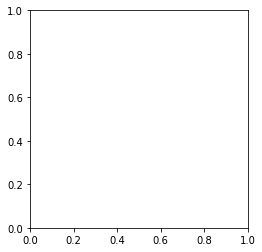

In [ ]:
io.imshow(train_weight_vectors[0], cmap=plt.cm.gray)